# 2. Topological Analysis

We are going to build our graph and do a topological analysis of it.

**Table of contents:**
- Build the graph
- Graph Statistics
- Centrality measure:
    1. Degree c.
    2. Betweenness c.
    3. Closeness c.
- Graph by subreddit

In [5]:
import praw
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx
from datetime import datetime

# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])

First we gather in a dataframe the data related to our comments.

In [6]:
# login with your reddit credentials

def login_reddit(reddit_credentials):
    with open(reddit_credentials, "r") as f:
        credentials = json.load(f)

    reddit = praw.Reddit(
        client_id=credentials['CLIENT_ID'],
        client_secret=credentials['SECRET_TOKEN'],
        password=credentials['PASSWORD'],
        user_agent='https://github.com/AlessandroGhiotto/WSA-AoT',
        username=credentials['USERNAME'],
        check_for_async=False
    )

    if reddit.read_only:
        print("Reddit login failed. Please check your credentials.")
        return None
    else:
        print(f"🤖 Reddit login successful. Welcome {reddit.user.me()}")
        return reddit
    
reddit_credentials = "../data/redditCredentials.json"
reddit = login_reddit(reddit_credentials)

🤖 Reddit login successful. Welcome Disastrous_Walk_7254


In [2]:
df_ending.head()

author            author_flair_text  clicked  \
0        joaopaulofoo        :Mikasa_looking_down:    False   
1  MarvelsGrantMan136                          NaN    False   
2          KingFedede                          NaN    False   
3         CurrentRisk                          NaN    False   
4           mellowlex  Pieck is Peak :Pieck_smile:    False   

                                            comments         created_utc  \
0  <praw.models.comment_forest.CommentForest obje... 2019-06-30 16:15:53   
1  <praw.models.comment_forest.CommentForest obje... 2022-04-03 17:34:19   
2  <praw.models.comment_forest.CommentForest obje... 2025-02-03 00:08:56   
3  <praw.models.comment_forest.CommentForest obje... 2024-08-11 17:23:18   
4  <praw.models.comment_forest.CommentForest obje... 2024-08-10 01:35:11   

  distinguished        edited       id  is_original_content  is_self  ...  \
0           NaN         False   c7ekxv                False     True  ...   
1           NaN         False   tvbyhy                False    False  ...   
2           NaN         False  1igajig                False     True  ...   
3           NaN  1723398887.0  1epnd1x                False     True  ...   
4           NaN  1723246803.0  1eoekl2                False     True  ...   

  poll_data  saved  score                                           selftext  \
0       NaN  False    336  #Discussion for anime onlies.\n\n#NO MANGA SPO...   
1       NaN  False   6115                                                NaN   
2       NaN  False      5  Guys I really need help now. I just finished t...   
3       NaN  False     57  I just watched the last episode of Attack on T...   
4       NaN  False      7  I finally got around to watch the the last epi...   

   spoiler  stickied      subreddit  \
0     True     False  attackontitan   
1     True     False  attackontitan   
2    False     False  attackontitan   
3    False     False  attackontitan   
4     True     False  attackontitan   

                                               title  upvote_ratio  \
0  Attack on Titan - Season 3 Episode 22 - "The O...          0.99   
1  'Attack on Titan: The Final Season - Part 3' A...          0.96   
2                   I just finished the last episode          1.00   
3                    Confused about the last episode          0.94   
4  I finished the last episode and have some ques...          0.82   

                                                 url  
0  https://www.reddit.com/r/attackontitan/comment...  
1                https://i.redd.it/tk52lyj92cr81.jpg  
2  https://www.reddit.com/r/attackontitan/comment...  
3  https://www.reddit.com/r/attackontitan/comment...  
4  https://www.reddit.com/r/attackontitan/comment...  

[5 rows x 27 columns]

Get the comments from our submssions, we gather until the third level (replies of the replies of the replies).

In [20]:
def create_comment_dict(parent_author, child_author, comment, sub, subreddit_name, sub_author, depth, parent_comment_id=None):
    """Create a dictionary with comment information to append to results"""
    return {
        'parent': parent_author,
        'child': child_author,
        'text_comment': comment.body,
        'comment_id': comment.id,
        'submission_id': sub.id,
        'subreddit': subreddit_name,
        'created_utc': comment.created_utc,
        'score': comment.score,
        'depth': depth,
        'parent_comment_id': parent_comment_id,
        'submission_author': sub_author,
        'is_submitter': comment.is_submitter,
    }

def get_comments(df):
    """Get comments from the top posts in the DataFrame till the third level"""
    res = []
    for _, row in df.iterrows():
        # find comment
        sub = reddit.submission(row['id'])
        sub.comments.replace_more(limit=20)
        subreddit_name = row['subreddit']
        # extract author of the submission
        sub_author = str(row['author'])

        # top level comments
        for tlc in sub.comments:
            res.append(create_comment_dict(sub_author, str(tlc.author), tlc, sub, subreddit_name, sub_author, 1))
            
            # second level comments
            for slc in tlc.replies:
                res.append(create_comment_dict(str(tlc.author), str(slc.author), slc, sub, subreddit_name, sub_author, 2, tlc.id))
    
                # third level comments
                for tl in slc.replies:
                    res.append(create_comment_dict(str(slc.author), str(tl.author), tl, sub, subreddit_name, sub_author, 3, slc.id))
                    
    return pd.DataFrame(res)


In [ ]:
# comments_df_general = get_comments(df_general)
# comments_df_general.to_csv('../data/comments_graph_general_top30percent.csv', index=False)
comments_df = get_comments(df_ending)
comments_df['created_utc'] = comments_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
comments_df.to_csv('../data/comments_graph_ending.csv', index=False)
print("length of comments df: ", len(comments_df))

length of comments df:  23475


In [22]:
comments_df.head()

parent       child  \
0  joaopaulofoo  Umer123321   
1    Umer123321        None   
2          None   s4l4o6t3h   
3          None  Umer123321   
4    Umer123321   ashai1994   

                                        text_comment comment_id submission_id  \
0   Armin Mikasa and Eren have finally seen the Sea.    esfm2ec        c7ekxv   
1  It was kinda bittersweet for Eren, but I liked...    esfz8rv        c7ekxv   
2  It being bittersweet for Eren was honestly my ...    esgxryv        c7ekxv   
3   We wait for a year for the ending to all of this    esfzc3d        c7ekxv   
4                                         How? where    eshkiwj        c7ekxv   

       subreddit   created_utc  score  depth parent_comment_id  \
0  attackontitan  1.561929e+09    398      1              None   
1  attackontitan  1.561939e+09    222      2           esfm2ec   
2  attackontitan  1.561973e+09    121      3           esfz8rv   
3  attackontitan  1.561939e+09     53      3           esfz8rv   
4  attackontitan  1.561995e+09      2      2           esfm2ec   

  submission_author  is_submitter  
0      joaopaulofoo         False  
1      joaopaulofoo         False  
2      joaopaulofoo         False  
3      joaopaulofoo         False  
4      joaopaulofoo         False

In [7]:
# load
# comments_df_general = pd.read_csv('../data/comments_graph_general_top30percent.csv')
comments_df = pd.read_csv('../data/comments_graph_ending.csv')
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'])

In [8]:
# Count occurrences of 'None' strings, 'nan' strings, and actual NaN values in comments_df_ending
none_string_count = (comments_df == 'None').sum().sum()
nan_string_count = (comments_df == 'nan').sum().sum()
actual_nan_count = comments_df.isna().sum().sum()

total_problematic_values = none_string_count + nan_string_count + actual_nan_count

print(f"'None' string occurrences: {none_string_count}")
print(f"'nan' string occurrences: {nan_string_count}")
print(f"Actual NaN occurrences: {actual_nan_count}")
print(f"Total problematic values: {total_problematic_values}")

print("\nProblematic values by column:")
print("'None' strings:")
print((comments_df == 'None').sum())
print("\n'nan' strings:")
print((comments_df == 'nan').sum())
print("\nActual NaN values:")
print(comments_df.isna().sum())

'None' string occurrences: 0
'nan' string occurrences: 0
Actual NaN occurrences: 18776
Total problematic values: 18776

Problematic values by column:
'None' strings:
parent               0
child                0
text_comment         0
comment_id           0
submission_id        0
subreddit            0
created_utc          0
score                0
depth                0
parent_comment_id    0
submission_author    0
is_submitter         0
dtype: int64

'nan' strings:
parent               0
child                0
text_comment         0
comment_id           0
submission_id        0
subreddit            0
created_utc          0
score                0
depth                0
parent_comment_id    0
submission_author    0
is_submitter         0
dtype: int64

Actual NaN values:
parent                1904
child                 3767
text_comment             0
comment_id               0
submission_id            0
subreddit                0
created_utc              0
score                    0
dept

In [9]:
def clean_comments_dataframe(df):
    """Remove rows with 'None' strings, 'nan' strings, or actual NaN values from comments dataframe"""
    df_clean = df[
        (df['parent'] != 'None') & 
        (df['child'] != 'None') &
        (df['parent'] != 'nan') & 
        (df['child'] != 'nan') &
        (~pd.isna(df['parent'])) & 
        (~pd.isna(df['child']))
    ]
    
    print(f"Original dataframe shape: {df.shape}")
    print(f"Cleaned dataframe shape: {df_clean.shape}")
    print(f"Removed {len(df) - len(df_clean)} rows")
    
    return df_clean

comments_df = clean_comments_dataframe(comments_df)
comments_df.shape
# this is going to be our final comments dataframe
comments_df.to_csv('../data/comments_graph_ending_clean.csv', index=False)

Original dataframe shape: (23475, 12)
Cleaned dataframe shape: (18163, 12)
Removed 5312 rows


## Build the Graph

We have chosen to build a Graph of Replies 

$$G = (N, E), \;\;\;N=\{\text{users}\} = \{u_1, u_2, \,\dots\,,u_n\},\;\;\; E = \{\text{comments}\} = \{(u_i, u_j) \,|\, u_j \text{ replied to } u_i\} $$
Even if comments have a direction, we treat it as an inderected graph, since we done really care to analyze the reply dynamics of the users, but we care just about interactions for analysing the communities.

In [36]:
# Create a graph from the cleaned comments dataframe
G = nx.Graph()
for index, r in comments_df.iterrows():
    G.add_edge(r['parent'], r['child'])

print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 9770 nodes and 13946 edges


In [37]:
# remove self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))
print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 9770 nodes and 13879 edges


In [38]:
# we take into consideration only the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print(f"Size of the largest connected component: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the largest connected component: 9719 nodes and 13848 edges


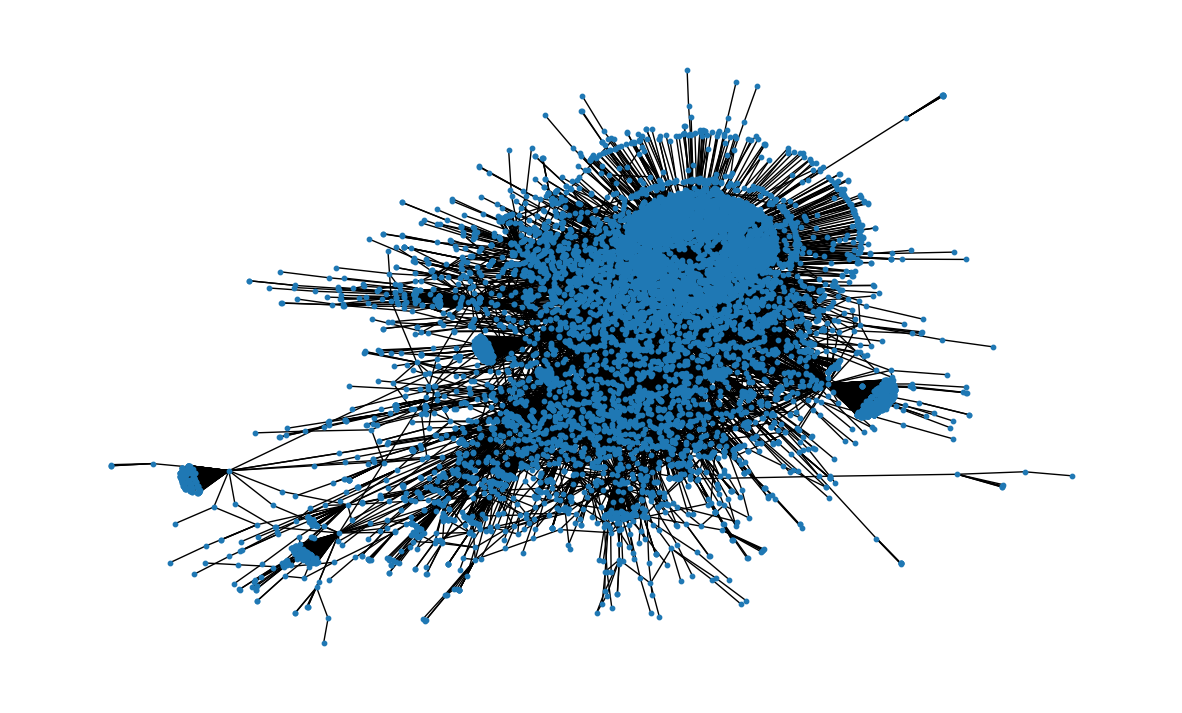

In [ ]:
# good seeds: 1729 (spread out nice horizontally), 1721 (more spiralish)
pos = nx.spring_layout(G, iterations=50, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False)

In [39]:
# some graph statistics
print("Radius:", nx.radius(G))
print("Diameter:", nx.diameter(G))
print("Average shortest path length:", round(nx.average_shortest_path_length(G), 5))
print("Average clustering coefficient:", round(nx.average_clustering(G), 5))
print("Density:", round(nx.density(G), 5))

Radius: 6
Diameter: 11
Average shortest path length: 3.57847
Average clustering coefficient: 0.10621
Density: 0.00031


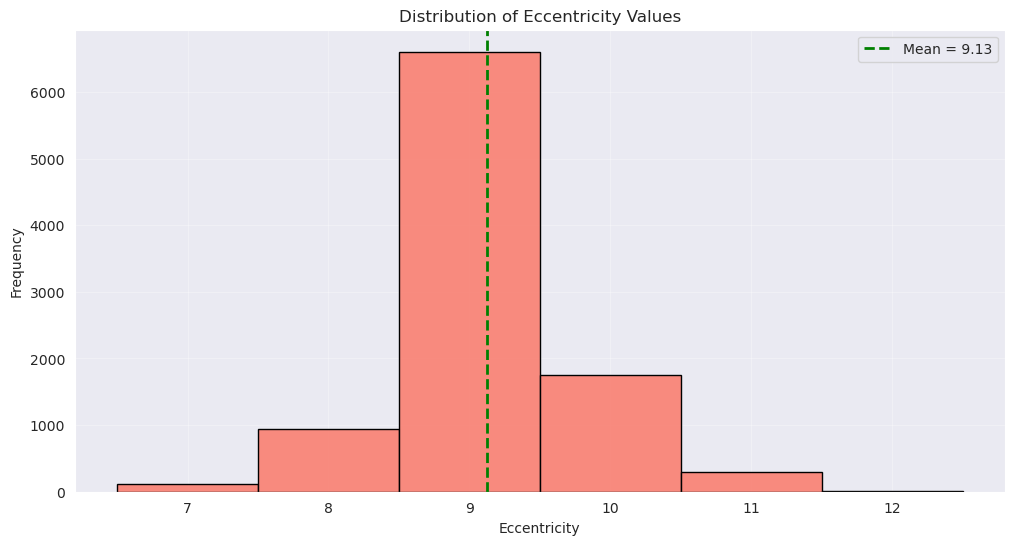

In [52]:
# eccentricity of the nodes
ecc = nx.eccentricity(G)

plt.figure(figsize=(12, 6))
# hitogram of the eccentricity values of our nodes
# center bins on integers
ecc_values = list(ecc.values())
min_ecc = min(ecc_values)
max_ecc = max(ecc_values)
bins = np.arange(min_ecc - 0.5, max_ecc + 1.5, 1)

sns.histplot(ecc_values, bins=bins, alpha=0.9, color='salmon', edgecolor='black')
plt.axvline(np.mean(ecc_values), color='green', linestyle='--', linewidth=2, label=f'Mean = {np.mean(ecc_values):.2f}')
plt.title('Distribution of Eccentricity Values')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.xticks(range(min_ecc, max_ecc + 1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

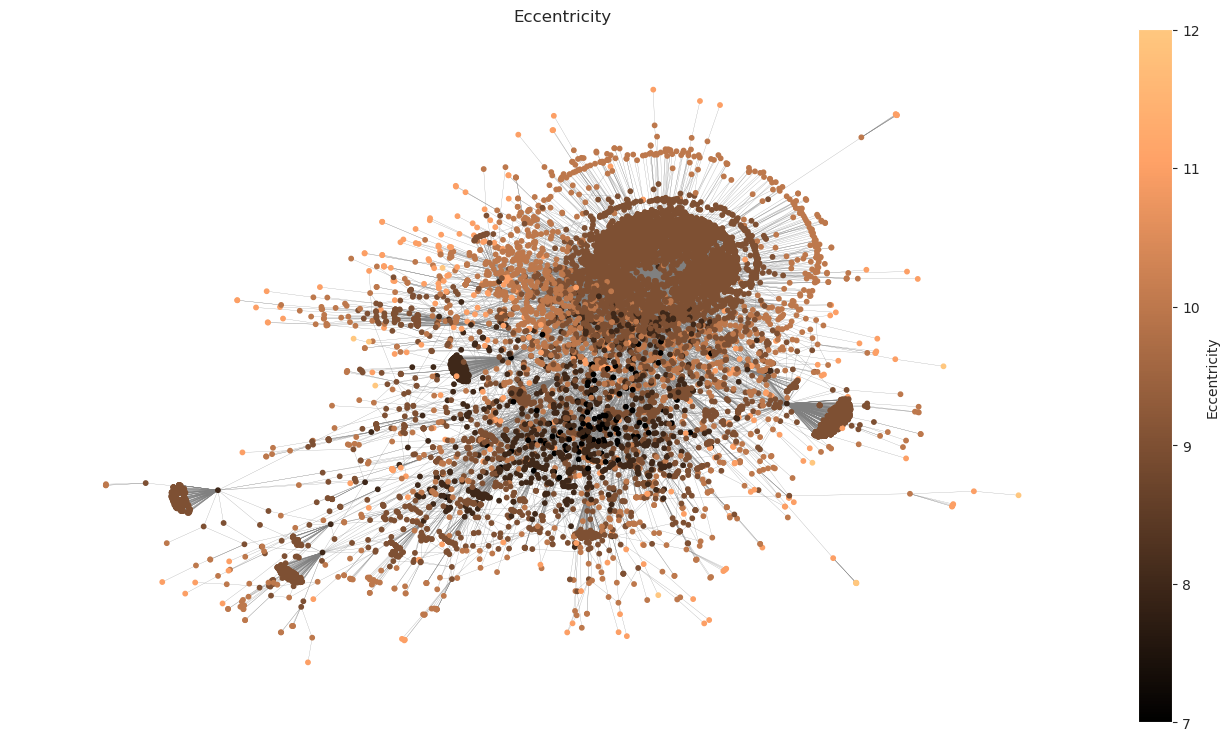

In [83]:
fig, ax = plt.subplots(figsize=(15, 9))
nodes = nx.draw_networkx(
    G, pos=pos, ax=ax, 
    node_color=list(ecc.values()), 
    cmap=plt.cm.copper, 
    edge_color='gray', 
    node_size=10, 
    with_labels=False, 
    width=0.15
)
ax.axis("off")
ax.set_title("Eccentricity")
sm = plt.cm.ScalarMappable(cmap=plt.cm.copper, norm=plt.Normalize(vmin=min_ecc, vmax=max_ecc))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label('Eccentricity')


In [84]:
# assortativity
r = nx.degree_assortativity_coefficient(G)
print(f"degree assortativity coefficient: {r:.4f}")

degree assortativity coefficient: -0.2023


With social network we should see a positive assortativity value, an assortativity lower than zero means that high-degree nodes tend to connect to low-degree ones. This is expected from a first inspection of our graph, since we have just this single huge cluster. So at the end our graph doesn't really show the behaviour of a complex network.

## Centrality measures

### 1. Degree Centrality

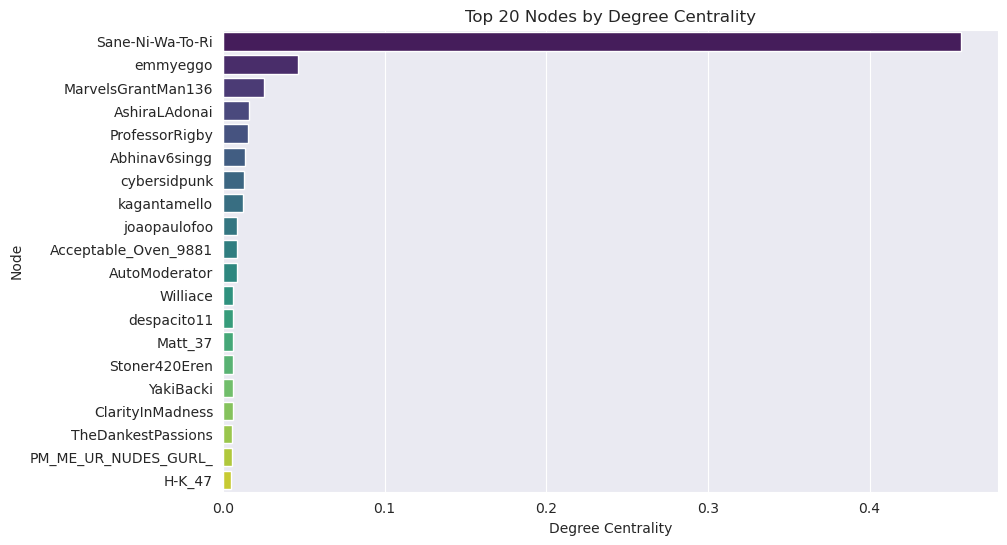

In [85]:
dg_cen = nx.degree_centrality(G)
dg_cen_df= pd.DataFrame(dg_cen.items(), columns=['node','dg_c'])
dg_cen_df = dg_cen_df.sort_values(by='dg_c', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='dg_c', y='node', data=dg_cen_df.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Node")
plt.show()

Mr. Sane-Ni-Wa-To-Ri is playing a big role in our aot discussions...

We encode the degree centrality as the node size

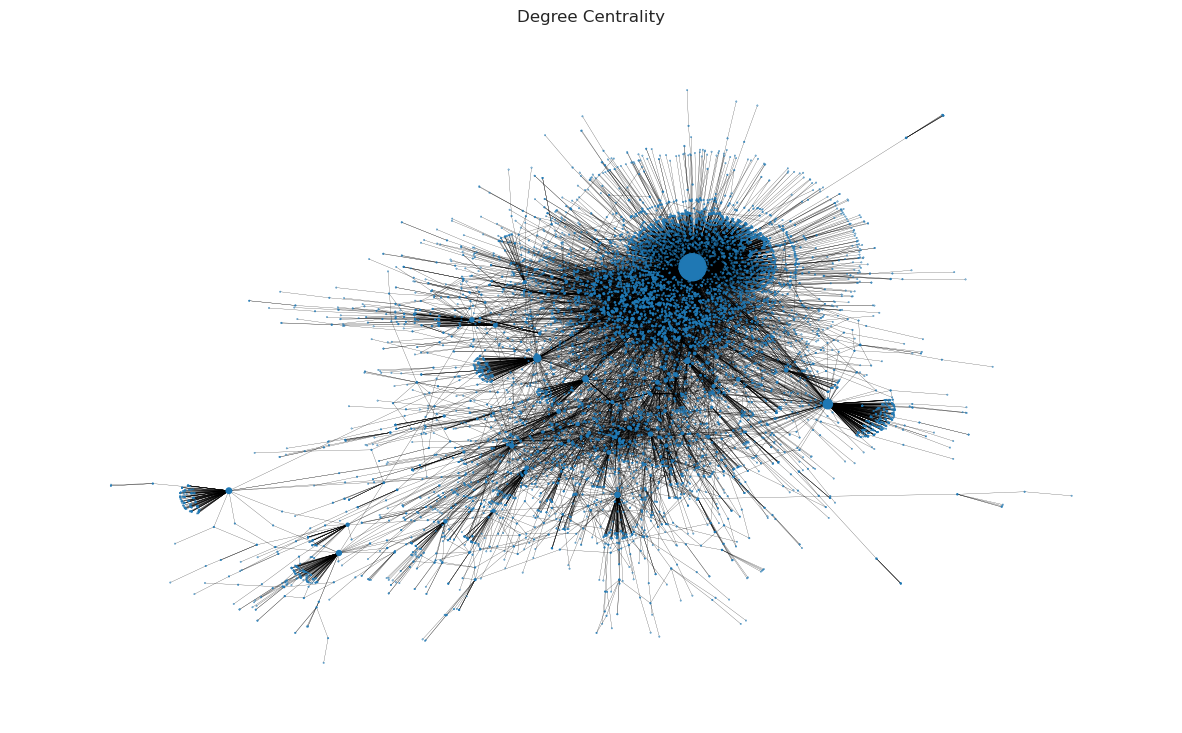

In [86]:
node_size = [np.log(v + 1) * 1000 for v in dg_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels= False, width= 0.15)
ax.set_title("Degree Centrality")
plt.show()

Highlights nodes with more neighobours. This is what we really care about for identifying the most replied/replying users.

### 2. Betweenness Centrality

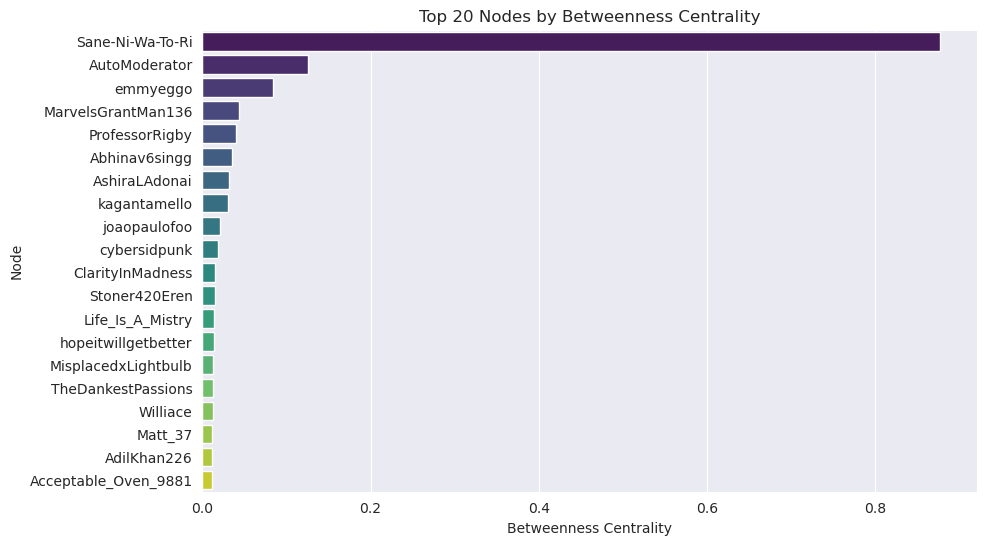

In [87]:
bt_cen = nx.betweenness_centrality(G)
bt_cen_df= pd.DataFrame(bt_cen.items(), columns=['node','bt_c'])
bt_cen_df = bt_cen_df.sort_values(by='bt_c', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='bt_c', y='node', data=bt_cen_df.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Node")
plt.show()

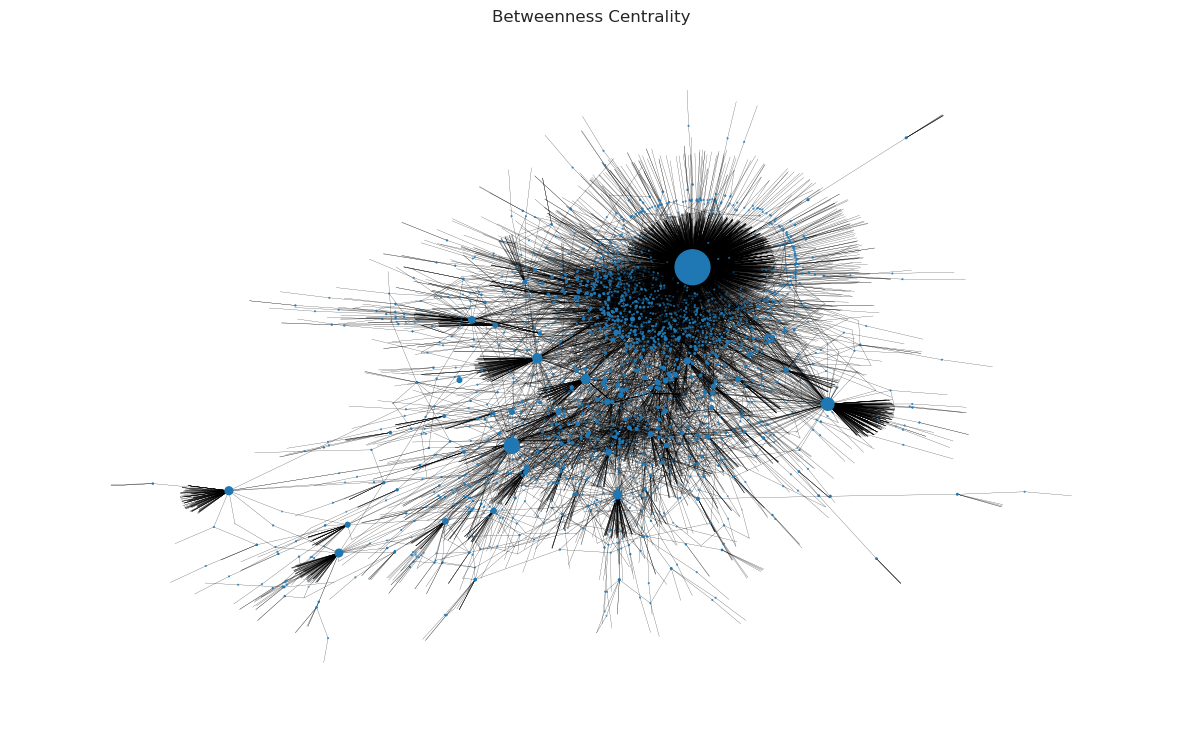

In [88]:
node_size = [np.log(v + 1) * 1000 for v in bt_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels= False, width= 0.15)
ax.set_title("Betweenness Centrality")
plt.show()

Hihglights nodes that are fundamental for the distribution of informations (bridge like points). They make as point of communication between different users.

### 3. Closeness Centrality

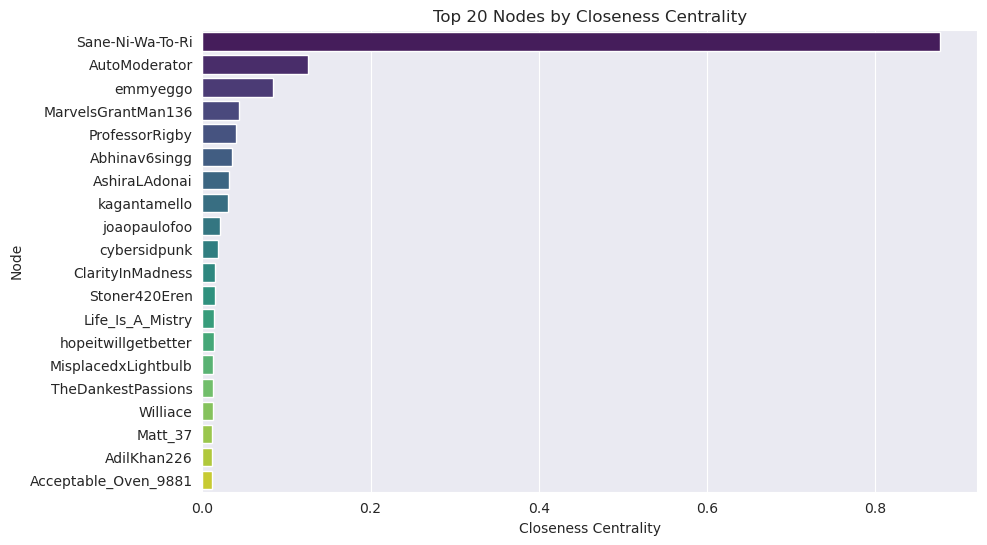

In [89]:
cl_cen = nx.closeness_centrality(G)
cl_cen_df= pd.DataFrame(bt_cen.items(), columns=['node','cl_c'])
cl_cen_df = cl_cen_df.sort_values(by='cl_c', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='cl_c', y='node', data=cl_cen_df.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Closeness Centrality")
plt.xlabel("Closeness Centrality")
plt.ylabel("Node")
plt.show()

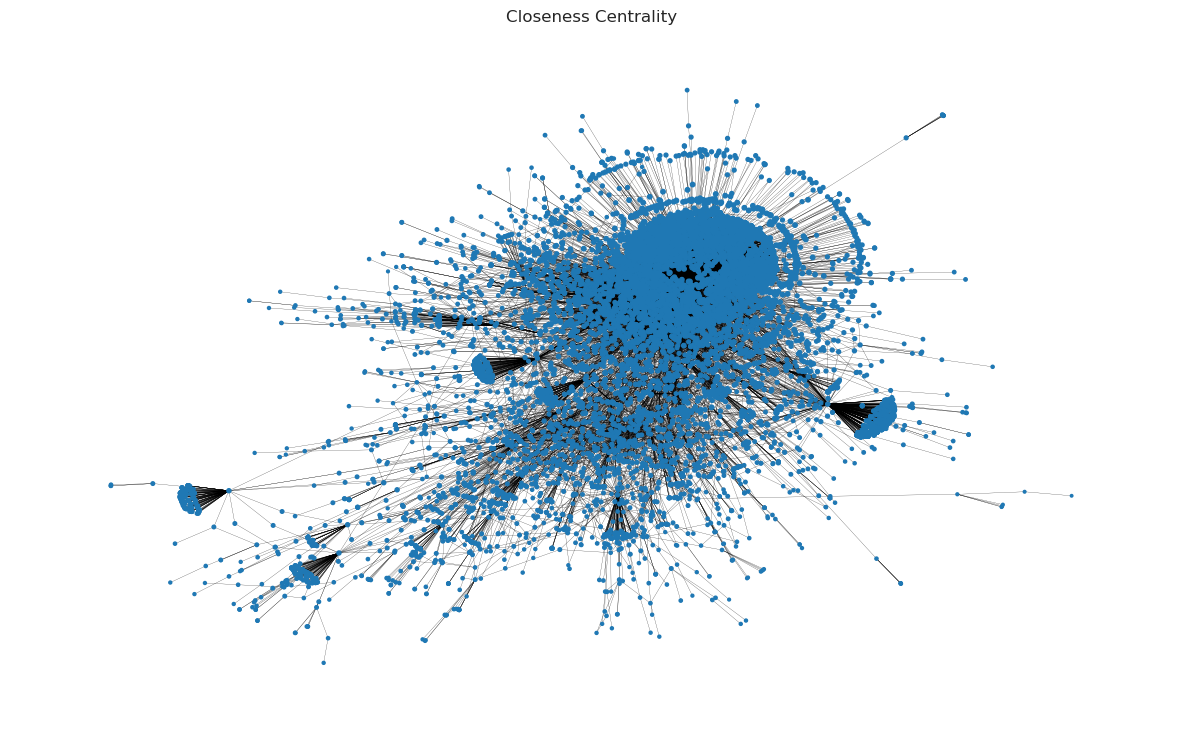

In [90]:
node_size = [v * 30 for v in cl_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels=False, width=0.15)
ax.set_title("Closeness Centrality")
plt.show()

In [ ]:
# store centrality measures in a unique pandas DataFrame
centrality_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree_centrality': [dg_cen[node] for node in G.nodes()],
    'betweenness_centrality': [bt_cen[node] for node in G.nodes()],
    'closeness_centrality': [cl_cen[node] for node in G.nodes()]
})
centrality_df.to_csv('../data/centrality_measures_ending.csv', index=False)
centrality_df.head()


node  degree_centrality  betweenness_centrality  \
0  joaopaulofoo           0.008952                0.021356   
1    Umer123321           0.000206                0.000000   
2     ashai1994           0.000412                0.000101   
3        Jdep11           0.000515                0.002251   
4  LordNelson27           0.000412                0.000412   

   closeness_centrality  
0              0.286439  
1              0.222681  
2              0.222691  
3              0.342605  
4              0.256615

## Graph by subreddit

We have gathered data from 3 different subreddits. We are going to plot the graph by specifying the color of the edges based on this 3 subreddits.

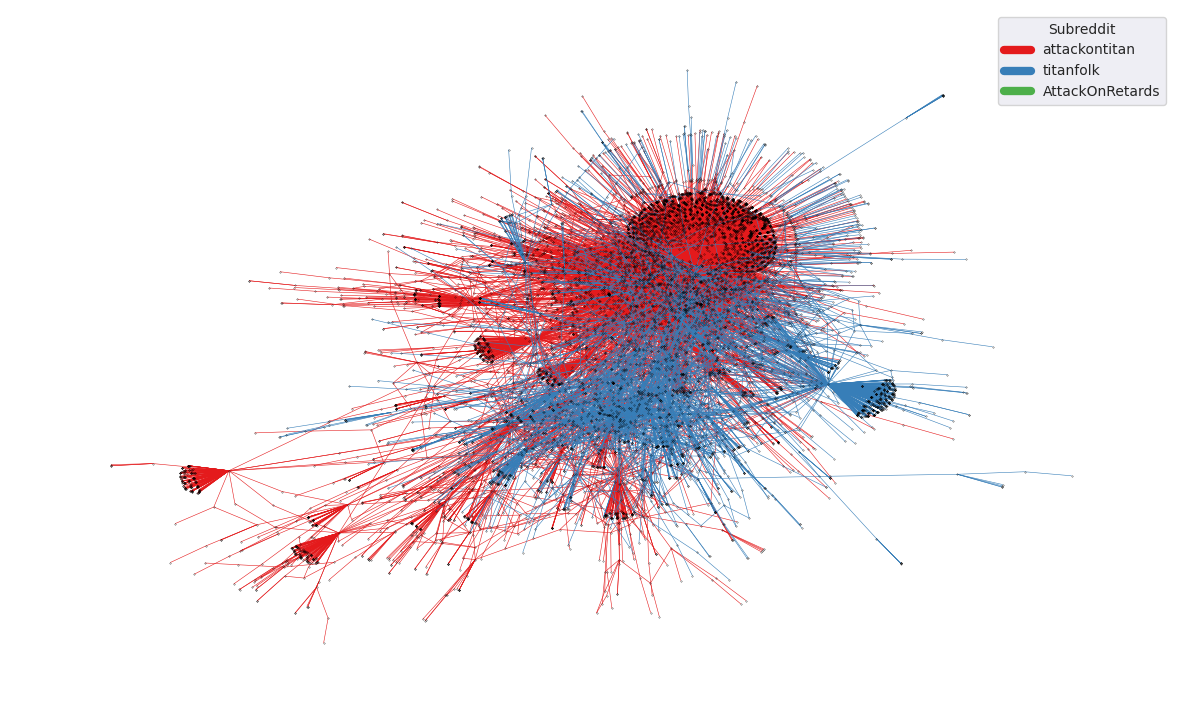

In [104]:
# subreddits to colors mapping
subreddits = comments_df['subreddit'].unique()
palette = sns.color_palette("Set1", n_colors=len(subreddits))
subreddit_to_color = {sub: palette[i] for i, sub in enumerate(subreddits)}

# assign colors to edges based on subreddit
edge_colors = [subreddit_to_color[sub] for sub in comments_df['subreddit']]

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(
    G, pos=pos, ax=ax, 
    node_color='black',
    edge_color=edge_colors, 
    node_size=0.05, 
    with_labels=False, 
    width=0.4
)
# Add legend
for sub, color in subreddit_to_color.items():
    ax.plot([], [], color=color, label=sub, linewidth=6)
ax.legend(title="Subreddit")
plt.show()

The big cluster centered on *Sane-Ni-Wa-To-Ri* is mostly based on the *attackontitan* subreddit. But the interaction between that and *titanfolk* is quite high. isntead *AttackOnRetards* is quite inexistent.

In [11]:
# Create a graph from the cleaned comments dataframe
G_attackontitan = nx.Graph()
G_titanfolk = nx.Graph()
G_attackonretards = nx.Graph()
for index, r in comments_df.iterrows():
    if r['subreddit'] == 'attackontitan':
        G_attackontitan.add_edge(r['parent'], r['child'])
    elif r['subreddit'] == 'titanfolk':
        G_titanfolk.add_edge(r['parent'], r['child'])
    elif r['subreddit'] == 'AttackOnRetards':
        G_attackonretards.add_edge(r['parent'], r['child'])

def remove_self_loops_and_largest_cc(G):
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    return G

# Remove self-loops and keep only the largest connected component for each subreddit graph
G_attackontitan = remove_self_loops_and_largest_cc(G_attackontitan)
G_titanfolk = remove_self_loops_and_largest_cc(G_titanfolk)
G_attackonretards = remove_self_loops_and_largest_cc(G_attackonretards)

print(f"Size of the AttackOnTitan graph: {G_attackontitan.number_of_nodes()} nodes and {G_attackontitan.number_of_edges()} edges")
print(f"Size of the TitanFolk graph: {G_titanfolk.number_of_nodes()} nodes and {G_titanfolk.number_of_edges()} edges")
print(f"Size of the AttackOnRetards graph: {G_attackonretards.number_of_nodes()} nodes and {G_attackonretards.number_of_edges()} edges")

Size of the AttackOnTitan graph: 6012 nodes and 8380 edges
Size of the TitanFolk graph: 3154 nodes and 4129 edges
Size of the AttackOnRetards graph: 782 nodes and 1316 edges


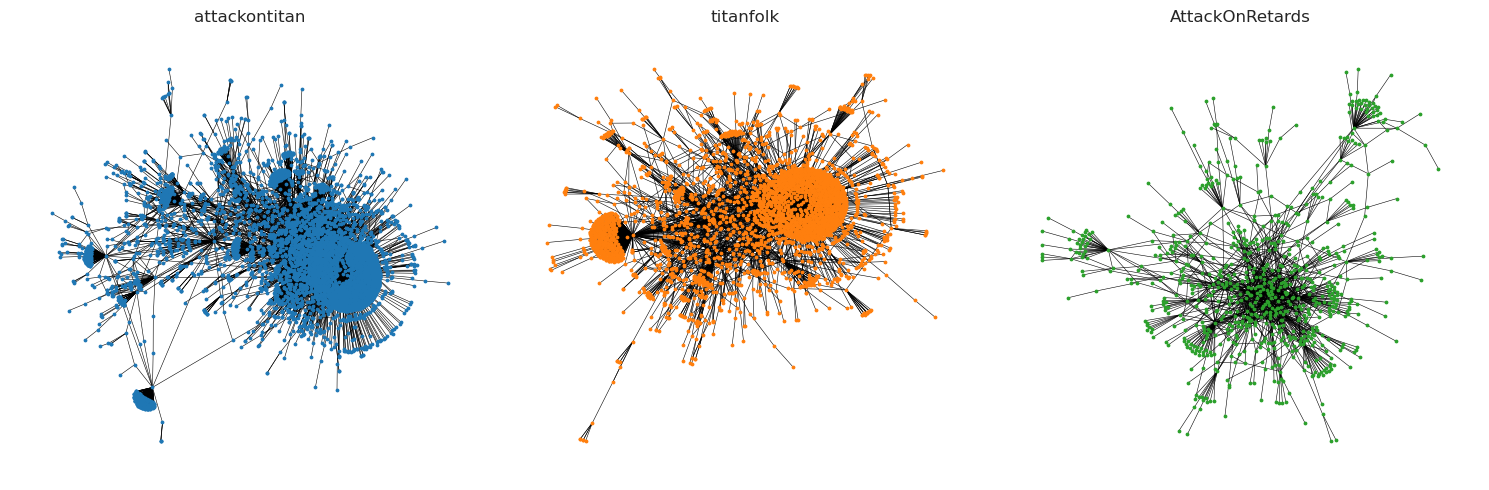

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
titles = ['attackontitan', 'titanfolk', 'AttackOnRetards']
graphs = [G_attackontitan, G_titanfolk, G_attackonretards]
poss = [nx.spring_layout(graph, iterations=50, seed=1721) for graph in graphs]
cmap = plt.cm.tab10

for i in range(3):
    ax = axes[i]
    nx.draw_networkx(graphs[i], pos=poss[i], ax=ax, node_size=3, width=0.4, node_color=[cmap(i)], with_labels=False)
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

---

In [106]:
# Align comments_df with the edges in the final graph G
# this because we have removed some edges from the graph
# when we have taken the largest connected component, or the self-loops

# Filter comments_df to only include rows where (parent, child) is an edge in G
graph_edges = set(G.edges())
comments_df = comments_df[comments_df.apply(lambda row: (row['parent'], row['child']) in graph_edges, axis=1)].copy()

# Reorder rows to match the order of edges in G
edge_list = list(G.edges())
comments_df.loc[:, 'edge_index'] = comments_df.apply(lambda row: edge_list.index((row['parent'], row['child'])), axis=1)
comments_df = comments_df.sort_values('edge_index').drop(columns='edge_index').reset_index(drop=True)

# Save the cleaned comments_df
comments_df.to_csv('../data/comments_graph_ending_final.csv', index=False)
print(f"Final comments_df shape: {comments_df.shape}")

Final comments_df shape: (14004, 12)


In [107]:
# save graph object to file
pickle.dump(G, open('../data/comments_graph.pickle', 'wb'))